In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path


def load_trajectories(csv_path: str | Path):
    """
    Lee el CSV de trayectorias generado por ExperimentRunner
    y devuelve:
      - df: DataFrame completo
      - swarm_size: número de partículas
      - dim: número de dimensiones (asumimos 2 para la visualización)
    """
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)

    particle_cols = [c for c in df.columns if c.startswith("p")]
    sample_particle = [c for c in particle_cols if c.startswith("p0_")]
    dim = len(sample_particle)
    swarm_size = len(particle_cols) // dim

    return df, swarm_size, dim


def rastrigin_2d_grid(xmin, xmax, ymin, ymax, n_points=200):
    """
    Genera un grid 2D de la función de Rastrigin para dim=2
    sobre el rectángulo [xmin,xmax] x [ymin,ymax].
    Devuelve X, Y, Z para usar en contour/contourf.
    """
    x = np.linspace(xmin, xmax, n_points)
    y = np.linspace(ymin, ymax, n_points)
    X, Y = np.meshgrid(x, y)

    A = 10.0
    Z = (
        A * 2
        + (X**2 - A * np.cos(2 * np.pi * X))
        + (Y**2 - A * np.cos(2 * np.pi * Y))
    )
    return X, Y, Z


def animate_trajectories(
    csv_path: str | Path,
    domain: tuple[float, float] = (-5.12, 5.12),
    save_path: str | Path | None = None,
    n_grid: int = 200,
):
    """
    Genera una animación 2D del movimiento de las partículas
    sobre un mapa de cotas de la función de Rastrigin 2D.

    Parámetros
    ----------
    csv_path : ruta al trajectories.csv
    domain   : (min, max) del dominio en X e Y
    save_path: si no es None, guarda la animación en ese fichero
               (ej: '.../traj.gif' o '.../traj.mp4').
    n_grid   : resolución del grid para el mapa de Rastrigin.
    """
    df, swarm_size, dim = load_trajectories(csv_path)

    if dim != 2:
        raise ValueError(f"Este visualizador está pensado para dim=2, pero se detectó dim={dim}")

    iters = df["iter"].to_numpy()
    n_frames = len(iters)

    # Matrices [n_frames, swarm_size] para X e Y
    xs = np.zeros((n_frames, swarm_size))
    ys = np.zeros((n_frames, swarm_size))

    for i in range(swarm_size):
        xs[:, i] = df[f"p{i}_x0"].to_numpy()
        ys[:, i] = df[f"p{i}_x1"].to_numpy()

    # ------------------- Figura + mapa de Rastrigin -------------------
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(domain[0], domain[1])
    ax.set_ylim(domain[0], domain[1])
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_title("PSO en Rastrigin 2D: trayectorias sobre el paisaje")
    ax.grid(True, alpha=0.3)

    # Mapa de cotas de Rastrigin
    Xg, Yg, Zg = rastrigin_2d_grid(domain[0], domain[1], domain[0], domain[1], n_points=n_grid)
    contour = ax.contourf(
        Xg,
        Yg,
        Zg,
        levels=40,
        cmap="viridis",   # puedes cambiar el mapa de color si quieres
        alpha=0.85,
    )
    fig.colorbar(contour, ax=ax, label="Valor de Rastrigin")

    # Nube de puntos (partículas actuales)
    scatter = ax.scatter(
        xs[0, :],
        ys[0, :],
        s=60,               # más grandes
        c="red",            # color de partículas actual
        edgecolor="white",  # borde blanco para destacar
        linewidth=0.8,
        alpha=1.0,          # completamente visibles
        zorder=3            # por encima del rastro y del mapa
    )

    # Líneas de rastro (super transparentes)
    trajectory_lines = []
    for _ in range(swarm_size):
        (line,) = ax.plot(
            [], [],
            linewidth=1.0,
            color="white",
            alpha=0.15,      # rastro MUY transparente
            zorder=1         # por debajo de las partículas
        )
        trajectory_lines.append(line)


    # Texto de iteración
    iter_text = ax.text(
        0.02,
        0.95,
        "",
        transform=ax.transAxes,
        fontsize=10,
        ha="left",
        va="top",
        color="white",
        bbox=dict(boxstyle="round", facecolor="black", alpha=0.3),
    )

    # ------------------- Funciones de animación -------------------
    def init():
        scatter.set_offsets(np.column_stack((xs[0, :], ys[0, :])))
        for line in trajectory_lines:
            line.set_data([], [])
        iter_text.set_text("iter = 0")
        return [scatter, *trajectory_lines, iter_text]

    def update(frame: int):
        scatter.set_offsets(np.column_stack((xs[frame, :], ys[frame, :])))

        for i, line in enumerate(trajectory_lines):
            line.set_data(xs[: frame + 1, i], ys[: frame + 1, i])

        iter_text.set_text(f"iter = {frame}")
        return [scatter, *trajectory_lines, iter_text]

    ani = FuncAnimation(
        fig,
        update,
        frames=n_frames,
        init_func=init,
        interval=80,   # algo más lento para que se vea bien
        blit=True,
    )

    # ------------------- Guardar (opcional) -------------------
    if save_path is not None:
        save_path = Path(save_path)

        # Si es un directorio o no tiene extensión, asumimos GIF
        if save_path.is_dir() or save_path.suffix == "":
            save_path = save_path / "trajectories_rastrigin.gif"

        print(f"Guardando animación en {save_path}...")
        ani.save(save_path, fps=8, dpi=150)
        print("Animación guardada correctamente.")

    plt.show()


Guardando animación en results/experimentos_D/experimento_D4/D4_trial_001/experimentoD4_video.mp4...
Animación guardada correctamente.


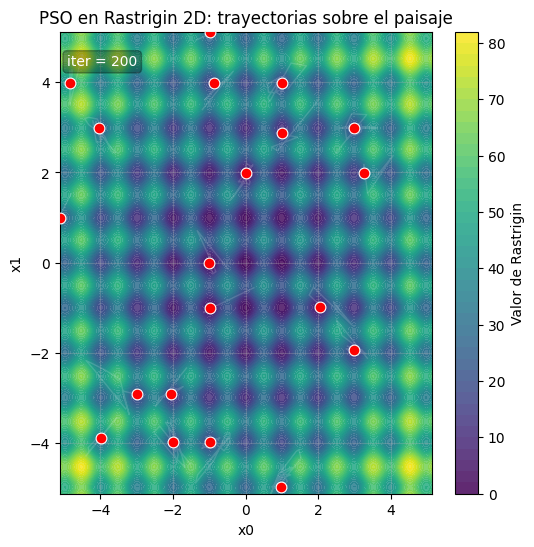

Guardando animación en results/experimentos_D/experimento_D4/D4_trial_001/experimentoD4_gif.gif...
Animación guardada correctamente.


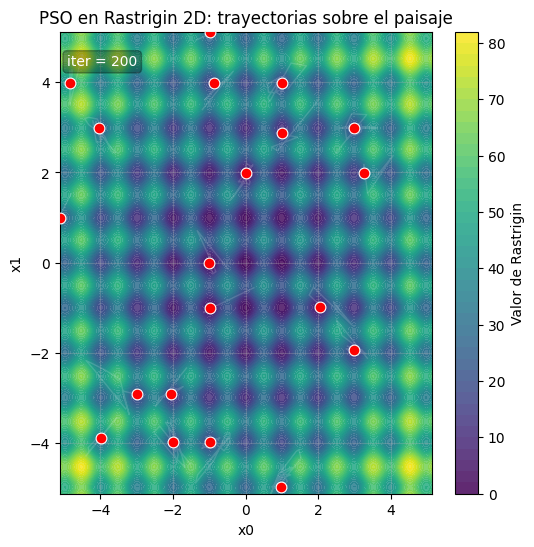

In [53]:
letra = "D"
numero = "4"

dir = f"./results/experimentos_{letra}/experimento_{letra}{numero}/{letra}{numero}_trial_001/"
csv_file = dir + "trajectories.csv"
video_file = dir + f"experimento{letra}{numero}_video.mp4"
gif_file = dir + f"experimento{letra}{numero}_gif.gif"

animate_trajectories(
    csv_path=csv_file,
    domain=(-5.12, 5.12),
    save_path=video_file
)

animate_trajectories(
    csv_path=csv_file,
    domain=(-5.12, 5.12),
    save_path=gif_file
)